In [1]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import seaborn as sns
import numpy as np

In [2]:
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

In [3]:
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

In [4]:
with open('pass.txt', 'r') as file:
    passw = file.read()
connection = create_db_connection("localhost", "root", passw, "droptime")

MySQL Database connection successful


In [5]:
q1 = """
SELECT *
FROM route_segments
WHERE segment_type='DRIVE';
"""

In [6]:
results = read_query(connection, q1)

In [7]:
from_db = []

for result in results:
  result = list(result)
  from_db.append(result)


columns = ["segment_id", "driver_id", "segment_type", "order_id", "segment_start_time", "segment_end_time"]
df = pd.DataFrame(from_db, columns=columns)

In [8]:
df = df.drop('segment_id', axis=1)

In [9]:
df['segment_start_time'] = pd.to_datetime(df['segment_start_time'])
df['segment_end_time'] = pd.to_datetime(df['segment_end_time'])

In [10]:
df['duration_mins'] = abs(((df['segment_end_time'] - df['segment_start_time']).dt.total_seconds())/60).round()
df['duration_secs'] = abs((df['segment_end_time'] - df['segment_start_time']).dt.total_seconds())

# Part 2.

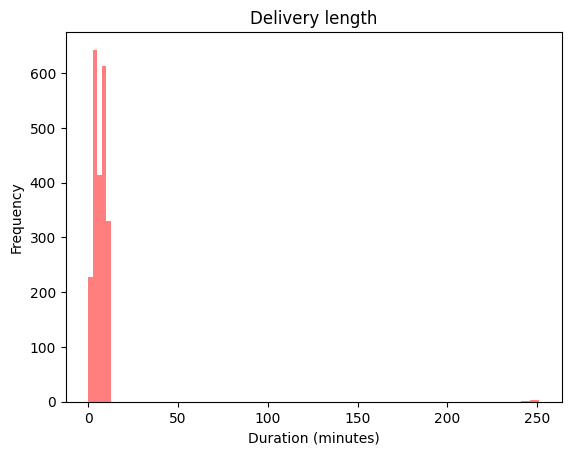

In [11]:
plt.hist(df['duration_mins'], bins=100, color='r', alpha=0.5)
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Delivery length')
plt.show()

In [12]:
q2 = """
SELECT *
FROM orders;
"""
results = read_query(connection, q2)

from_db = []

for result in results:
  result = list(result)
  from_db.append(result)


columns = ["order_id", "customer_id", "sector_id", "planned_delivery_duration"]
df2 = pd.DataFrame(from_db, columns=columns)
df2 = df2.drop('order_id', axis=1)

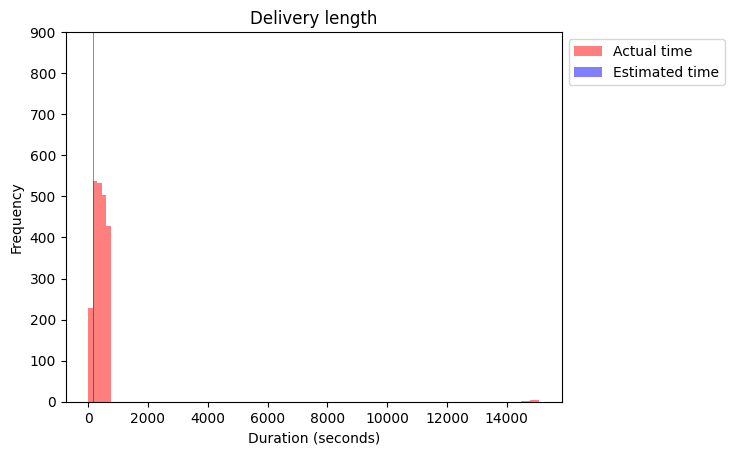

In [13]:
plt.hist(df['duration_secs'], bins=100, color='r', alpha=0.5, label='Actual time')
plt.hist(df2['planned_delivery_duration'], bins=2, color='b', alpha=0.5, label='Estimated time')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Delivery length')
plt.ylim(0,900)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

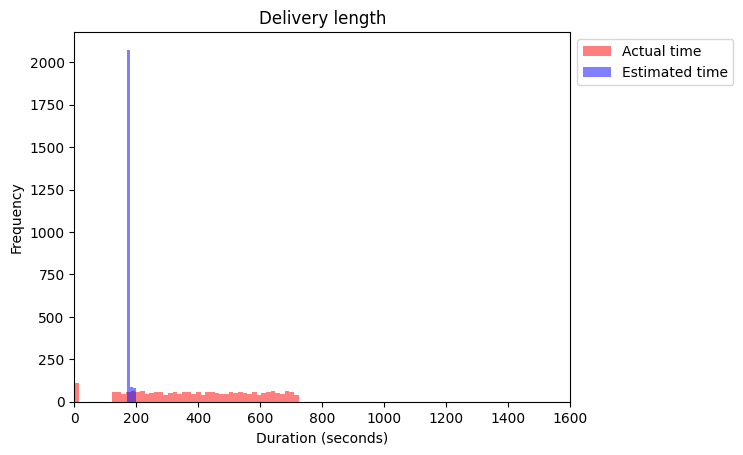

In [14]:
plt.hist(df['duration_secs'], bins=1000, color='r', alpha=0.5, label='Actual time')
plt.hist(df2['planned_delivery_duration'], bins=3, color='blue', alpha=0.5, label='Estimated time')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Delivery length')
plt.xlim(0, 1600)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [15]:
q3 = """
SELECT o.sector_id , rs.segment_start_time, rs.segment_end_time
FROM orders o
JOIN route_segments rs ON o.order_id = rs.order_id;
"""

In [16]:
results = read_query(connection, q3)

from_db = []

for result in results:
  result = list(result)
  from_db.append(result)

columns = ["sector_id", "start_time", "end_time"]
df3 = pd.DataFrame(from_db, columns=columns)

In [17]:
df3['start_time'] = pd.to_datetime(df3['start_time'])
df3['end_time'] = pd.to_datetime(df3['end_time'])

In [18]:
df3['duration_mins'] = abs(((df3['end_time'] - df3['start_time']).dt.total_seconds())/60).round()
df3['duration_secs'] = abs((df3['end_time'] - df3['start_time']).dt.total_seconds())

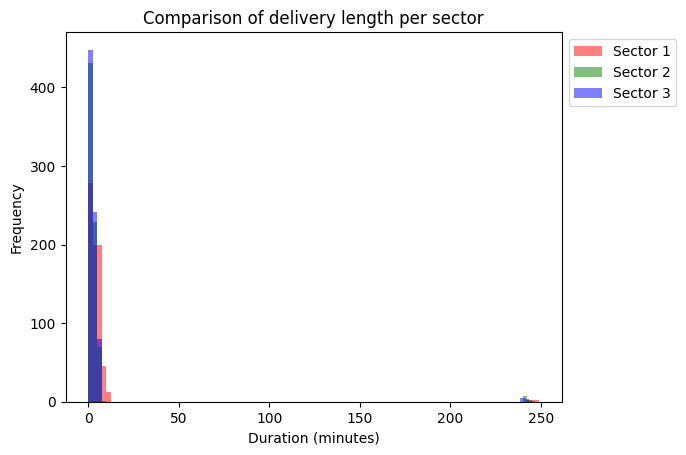

In [19]:
sectors = df3['sector_id'].unique()
colors = ['red', 'green', 'blue']

for i, sector in enumerate(sectors):
    sector_data = df3[df3['sector_id'] == sector]['duration_mins']
    plt.hist(sector_data, bins=100, color=colors[i], alpha=0.5, label=f'Sector {sector}')
plt.title('Comparison of delivery length per sector')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

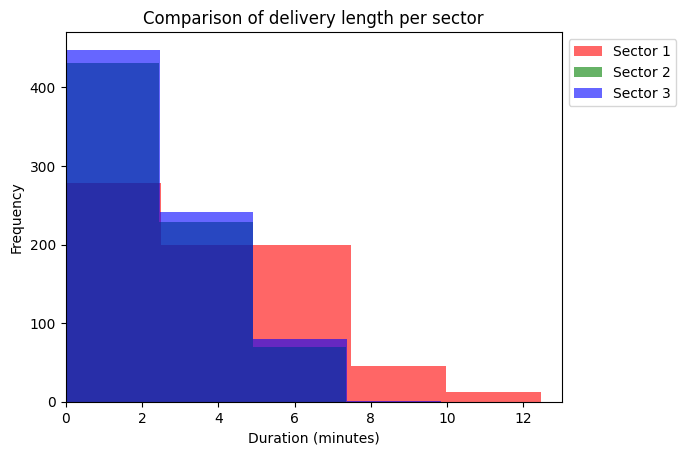

In [20]:
for i, sector in enumerate(sectors):
    sector_data = df3[df3['sector_id'] == sector]['duration_mins']
    plt.hist(sector_data, bins=100, color=colors[i], alpha=0.6, label=f'Sector {sector}')
plt.title('Comparison of delivery length per sector')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.xlim(0, 13)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

As shown above, sector 1 is taking way more time than either sector 2 or 3.

Considering all of the variables present in the database, I do not think that things like:
- order_id
- product_id
would have any relationship with the shipping time.

Things I cannot evaluate more on:
- quantity
- weight
- customer_id
It makes the car heavier but it shouldn't really impact the time of arrival of the package but rather the fuel consumption. Customer ID might be of use since some of the customers might create delays but I do not think the amount of them is so great for it to actually matter.

__Things that I think might be worth considering investigating are:__
- __driver_id__ (perhaps the driver drives slower than others)
- __segment_start_time__ (might show whether the time of the day makes the traffic more congested)

In [21]:
df4 = df.drop(['segment_type', 'segment_end_time', 'order_id', 'duration_mins'], axis=1)

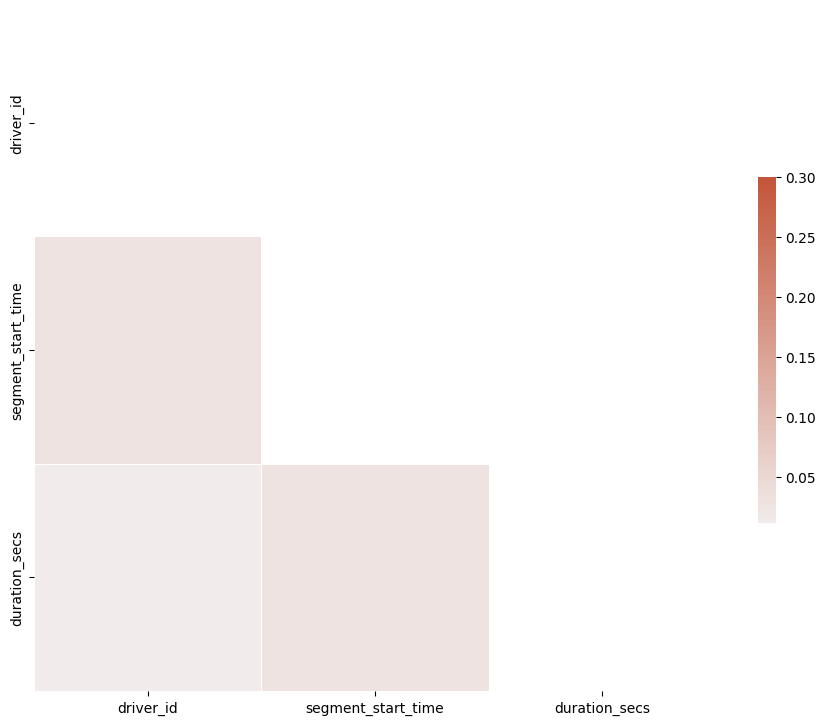

In [22]:
corr = df4.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

The correlation matrix shows that there is little to none correlation between selected features and the delivery time.

# Part 3.

1. Predicting delivery times per sector might be a good idea since it has been shown above that sector 1 usually takes more time to deliver the package than the other ones. I would validate it by plotting the newly calculated estimated time per sector and compare it to the real values. 

2. Since I am a Data Science major, I would create an AI regression model to calculate the estimated delivery times. The model can validate itself with the usage of accuracy and F-1 score metrics.

3. Recipients not answering the phone when the package is being delivered, the distance from entrance, weather condition, no parking spots.

4. Weather conditions for each day, emergencies of a delivery man, traffic patterns.

5. Under-estimating delivery times might result in:
- long waiting times for customers what certainly would make them dissatisfied
- not enough time for the delivery man to deliver all the parcels or overtime necessity

Over-estimating might result in:
- not meeting the clients availability time
- carrier spending more time in work than estimated which might result in overtime as mentioned above  
                                                    